In [2]:
pip install finance-datareader

Note: you may need to restart the kernel to use updated packages.


In [93]:
import re
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

In [ ]:
conda install -n base ipykernel --update-deps --force-reinstall

In [4]:
#특정 날짜 23년 2월 2일 크롤링
url = 'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list23&wr_id=2190#section1'
response = requests.get(
    url,
    headers={
        'User-Agent': 'Mozilla 5.0'
    }
    )
bs = BeautifulSoup(response.text, 'lxml')    

In [167]:
#특정 날짜 23년 2월 2일 크롤링
df = pd.DataFrame(columns=['comment'])
for i in range(len(bs.select('.cmt_contents'))):
    comment = bs.select('.cmt_contents')[i].text
    df.loc[i] = [comment]

In [4]:
#게시판에서 각 게시물 주소얻기 
url = 'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list23'
response = requests.get(
    url,
    headers={
        'User-Agent': 'Mozilla 5.0'
    }
    )
bs = BeautifulSoup(response.text, 'lxml') 

In [200]:
#1페이지 링크 얻기
for i in range(len(bs.select('table>tr'))):
    date = bs.select('table>tr')[i].select('dd')[1].text
    url_link = bs.select('table>tr')[i].select('a')[0].get('href')

In [5]:
#해당 년도 모든 페이지에 날짜 url 얻기
#마지막 페이지 찾는 작업 필요 
for page_num in range(1,4):
    url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list22&page={page_num}'
    response = requests.get(
        url,
        headers={
        'User-Agent': 'Mozilla 5.0'
        }
        )
    bs = BeautifulSoup(response.text, 'lxml') 

    for i in range(len(bs.select('table>tr'))):
        date = bs.select('table>tr')[i].select('dd')[1].text
        url_link = bs.select('table>tr')[i].select('a')[0].get('href')

In [2]:
#함수화
def get_info_from_url(url):
    response = requests.get(
        url,
        headers={
        'User-Agent': 'Mozilla 5.0'
        }
    )
    bs = BeautifulSoup(response.text, 'lxml') 
    return bs

In [37]:
def get_lastpage_num(url):
    url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list{i}&page=1'
    bs = get_info_from_url(url)  
    page = bs.select('.color-gray')[0].text.strip()
    page_num = math.ceil(int(re.findall('\d+',page)[0])/15)
    return page_num

In [39]:
#모든 년도 모든 페이지에 날짜 url 얻기
#마지막 페이지 찾는 작업 필요 
df = pd.DataFrame()
for year in tqdm(range(19,24)):
    url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list{year}&page=1'
    last_page_num = get_lastpage_num(url)
    for page_num in tqdm(range(last_page_num + 1)):
        url = f'http://www.fantastock.co.kr/bbs/board.php?bo_table=free_list{year}&page={page_num}'
        bs = get_info_from_url(url)  
        info_from_bs = bs.select('table>tr')
        for bs in info_from_bs:
            try :
                date = bs.select('dd')[1].text
                url_link = bs.select('a')[0].get('href')
                bs = get_info_from_url(url_link)
                data_from_url = bs.select('.cmt_contents')

                for comments in data_from_url:
                    comment = comments.text

                    temp = pd.DataFrame({
                        'date': date,
                        'url': url_link,
                        'comment': comment
                        }, index=[0])

                    df = pd.concat([df, temp], axis=0)
            except IndexError:
                print(1)

100%|██████████| 5/5 [04:05<00:00, 49.02s/it]

1
1


In [40]:
df

,date,url,comment
0,2019.12.30,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n오늘 무료추천종목은 제가 올해의 증권경영인 시상식에 참여를 해야되어서 하루...
0,2019.12.30,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n내일은 12월31일이라 주식시장이 열리지않고 1월1일은 신정연휴라 쉬고 1월...
0,2019.12.30,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n회사 업무는 정상진행됩니다. \n
0,2019.12.30,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n※ AP투자연구소 김용재 소장 V.I.P 리딩 특징 ※ 1.무료추천주와는...
0,2019.12.30,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n \n
...,...,...,...
0,2022.12.19,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n\n
0,2022.12.19,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n\n
0,2022.12.19,http://www.fantastock.co.kr/bbs/board.php?bo_t...,\n\n \n
0,2022.12.19,http://www.fantastock.co.kr/bbs/board.php?bo_t...,"\n\n코스피 하락, 코스닥 하락거래소 : 개인 매도 / 외국인 매도 / 기관 매수..."


In [41]:
#파일로 저장
df.to_csv('data.csv', index=False, encoding='utf-8-sig')


In [42]:
#파일 불러오기
df = pd.read_csv('./data.csv')

In [43]:
#금일 추천주 필터링
df = df[df['comment'].str.contains('매수', na =False)]
df = df[df['comment'].str.contains('현재시간', na =False)]
df = df[df['comment'].str.contains('▶', na =False)]
df['comment'] = df.comment.apply(lambda x : re.sub('\\n','',x))

In [46]:
#date 를 datetime 형식으로 변환 1
df['date'] = df.date.apply(lambda x : x.replace(".",""))
df['date']= df['date'].astype('str')
df['date'] = df.date.apply(lambda x : datetime.strptime(x,'%Y%m%d'))
df = df.reset_index(drop=True)

In [49]:
df.to_csv('data.csv', index=False, encoding='utf-8-sig')

In [63]:
#date 를 datetime 형식으로 변환 2
#df2 = df 
#df2['date'] = pd.to_datetime(df2['date'])

In [64]:
# # 예외찾기
# df2 = df['slicing_comment'].apply(lambda x : x == [] )
# df2[df2]

In [2]:
df = pd.read_csv('./data.csv')

In [4]:
df['comment'] = df.comment.apply(lambda x : x.replace('\xa0',' '))

In [5]:
#종목 슬라이스
df['slicing_comment'] = df.comment.apply(lambda x : re.findall('\d+분 ([가-힣A-z]+)',x)[0])

In [6]:
#종목명 추출
recommended_stock = df.filter(items=['date','slicing_comment'])
recommended_stock = recommended_stock.rename(columns={'slicing_comment':'stock_name'})

In [68]:
#데이터프레임 한번에 보기
#pd.set_option('display.max_rows', None)
#다시 돌리기
#pd.options.display.max_rows = 100

In [7]:
#대소변환
recommended_stock['stock_name'] = recommended_stock.stock_name.str.upper()

In [8]:
#주가 기본정보 불러오기
Kospi_df = pd.read_csv('./kospi_code.csv')
Kosdaq_df = pd.read_csv('./kosdaq_code.csv')

In [9]:
kospi = Kospi_df.filter(items= ['단축코드','한글명'])
kospi['class'] = 'kospi'

In [10]:
kosdaq = Kosdaq_df.filter(items= ['단축코드','한글종목명'])
kosdaq['class'] = 'kospi'

In [11]:
#주가 종목코드 불러오기
kospi = kospi.rename(columns={'단축코드':'stock_code','한글명' : 'stock_name'})
kosdaq = kosdaq.rename(columns={'단축코드':'stock_code','한글종목명' : 'stock_name'})
kospi_kosdaq = pd.concat([kospi,kosdaq])

In [12]:
#종목 코드 합치기 1트
stock = pd.merge(recommended_stock, kospi_kosdaq, how = 'left', on  = 'stock_name')

In [13]:
#누락된NaN 버리기
stock1 = stock.dropna()

In [89]:
#누락된 종목코드 찾기
# exception = stock[stock.stock_code.isnull()]
exception = stock.drop(stock1.index,axis=0)

In [90]:
#파일로 저장
#exception.to_csv('exception2.csv', index=False, encoding='utf-8-sig')

In [14]:
#파일불러오기
exception = pd.read_csv('./exception2.csv')

In [15]:
exception = exception.dropna()
exception['stock_code'] = exception.stock_code.apply(lambda x : str(int(x)).zfill(6))

In [17]:
exception_kospi_kosdaq=kospi_kosdaq.drop(columns=['stock_name'])
exception = pd.merge(exception,exception_kospi_kosdaq,how = 'left', on  = 'stock_code'  )

In [18]:
#최종 stock 가져오기 stock = stock1+stock2
stock = pd.concat([stock1,exception])
stock = stock.sort_values(by=['date'], ascending=[True])
stock = stock.reset_index(drop= True)

In [22]:
#파일로 저장
stock.to_csv('recommend_stock2.csv', index=False, encoding='utf-8-sig')
#파일 불러오기
stock = pd.read_csv('./recommend_stock2.csv')

In [23]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        1280 non-null   object
 1   stock_name  1280 non-null   object
 2   stock_code  1280 non-null   object
 3   class       1280 non-null   object
dtypes: object(4)
memory usage: 40.1+ KB


In [25]:
stock['date'] = stock.date.apply(lambda x : re.sub("-","",x))
stock['date']= stock['date'].astype('str')
stock['date'] = stock.date.apply(lambda x : datetime.strptime(x,'%Y%m%d'))

In [32]:
stock

,date,stock_name,stock_code,class
0,2019-10-29,알리코제약,260660,kospi
1,2019-10-29,KPX생명과학,114450,kospi
2,2019-10-29,제일바이오,052670,kospi
3,2019-10-30,광진실업,026910,kospi
4,2019-10-30,아스타,246720,kospi
...,...,...,...,...
1275,2023-02-16,성우하이텍,015750,kospi
1276,2023-02-20,엔켐,348370,kospi
1277,2023-02-20,엔켐,348370,kospi
1278,2023-02-21,대주산업,003310,kospi


In [41]:
#date 타입 날짜 문자로 바꾸기
stock['end_date']= stock['date'].astype('str')
stock['end_date'] = stock.end_date.apply(lambda x : re.sub("-","",x))

In [42]:
#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

In [43]:
#일자별 시세 가져오기 (함수)
def get_info_from_kisapi(stock_code,end_date):
    time.sleep(0.1)
    
    st_date = pd.date_range(end = end_date,periods=20)[0]
    st_date = st_date.strftime("%Y%m%d")
    
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST03010100"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":stock_code,
        "FID_INPUT_DATE_1" : st_date,
        "FID_INPUT_DATE_2" : end_date,
        "FID_PERIOD_DIV_CODE" : "D",
        "FID_ORG_ADJ_PRC" : "1"
    }

    res = requests.get(URL, headers=headers, params=params)   
    res = res.json().get('output2')[0:11]
    res.reverse()
    return res

In [44]:
#종목 일자별 데이터 가져오기 (함수)
def get_info_from_stock(res):
    temp = pd.DataFrame()
    day = 10
    for i in res:

        data = pd.DataFrame({
            'stck_oprc' :  i.get('stck_oprc'),
            'stck_clpr' : i.get('stck_clpr'),
            'stck_hgpr' : i.get('stck_hgpr'),
            'stck_lwpr' : i.get('stck_lwpr'),
            'acml_vol'  : i.get('acml_vol')},
            index=[f'D{day}']
        )
        temp = pd.concat([temp,data])
        day -=1
    temp= temp.transpose()
    
    br_pr = temp.iloc[1:2,9:10].reset_index(drop = True)
    br_pr.columns = 'br_pr_'+ br_pr.columns
    #당일시가
    tr_pr = temp.iloc[0:1,10:].reset_index(drop = True)    
    tr_pr.columns = 'tr_pr_'+ tr_pr.columns
    #당일고가
    tr_hpr = temp.iloc[2:3,10:].reset_index(drop = True)
    tr_hpr.columns = 'tr_hpr_'+ tr_hpr.columns
    #거래량(10일)
    br_vol = temp.iloc[4:5,0:10].reset_index(drop = True)
    br_vol.columns = 'Volume_'+ br_vol.columns
    #당일거래량
    tr_vol = temp.iloc[4:5,10:].reset_index(drop = True)
    tr_vol.columns = 'tr_vol_'+ tr_vol.columns
    #저점(10일)
    br_lpr = temp.iloc[3:4,0:10].reset_index(drop = True)
    br_lpr.columns = 'lpr_'+ br_lpr.columns
    #데이터 합치기 
    data = pd.concat([br_pr,tr_pr,tr_hpr,br_vol,tr_vol,br_lpr], axis=1)
    # #인덱스 삽입
    # date_data = pd.DataFrame({'date' : end_date,
    #                         'stock_code' : stock_code}
    #                         ,index=[0])
    # data = pd.concat([date_data,data], axis =1 )
    
    return data   

In [45]:
#전종목 가져오기
data = pd.DataFrame()
for i in range(len(stock)):
    end_date = stock.end_date[i]
    stock_code = stock.stock_code[i]
    res = get_info_from_kisapi(stock_code,end_date)
    temp = get_info_from_stock(res)
    data = pd.concat([data,temp],axis=0)
# data = data.drop(columns=['date','stock_code'])
# data = data.reset_index().drop(columns = 'index')

In [48]:
stock

,date,stock_name,stock_code,class,end_date
0,2019-10-29,알리코제약,260660,kospi,20191029
1,2019-10-29,KPX생명과학,114450,kospi,20191029
2,2019-10-29,제일바이오,052670,kospi,20191029
3,2019-10-30,광진실업,026910,kospi,20191030
4,2019-10-30,아스타,246720,kospi,20191030
...,...,...,...,...,...
1275,2023-02-16,성우하이텍,015750,kospi,20230216
1276,2023-02-20,엔켐,348370,kospi,20230220
1277,2023-02-20,엔켐,348370,kospi,20230220
1278,2023-02-21,대주산업,003310,kospi,20230221


In [51]:
data = data.reset_index().drop(columns=['index'])

In [52]:
stock = pd.concat([stock, data], axis=1)

In [68]:
stock = stock.fillna(0)
for cn in stock.columns[4:]:
    stock[f'{cn}'] = stock[f'{cn}'].apply(lambda x : int(x))

In [77]:
stock.iloc[:,19:29]

,lpr_D10,lpr_D9,lpr_D8,lpr_D7,lpr_D6,lpr_D5,lpr_D4,lpr_D3,lpr_D2,lpr_D1
0,11750,11750,12500,12100,12200,12300,12650,12050,11750,11600
1,3975,3990,3970,3970,4000,4390,4830,4735,4925,6250
2,5070,4990,5130,5060,5060,4820,4665,4540,4425,4510
3,4190,4125,4510,4235,4145,4235,4100,4085,3940,3920
4,4730,4695,4690,4670,4740,4670,4595,4550,5080,6890
...,...,...,...,...,...,...,...,...,...,...
1275,5070,5100,5100,5150,5260,5270,5220,5290,5330,5380
1276,61000,60900,62800,62700,62300,60900,60900,60600,61300,61200
1277,61000,60900,62800,62700,62300,60900,60900,60600,61300,61200
1278,2350,2370,2340,2290,2395,2385,2325,2340,2305,2370


In [94]:
#전일 종가 대비 당일 시가 증가율
stock['gap_change'] = stock.iloc[:,5:7].pct_change(axis =1).dropna(axis=1)

#전일(10일) 거래량 대비 당일 거래량 증가율 
stock['mean_vlome'] = stock.iloc[:,7:17].mean(axis =1)
stock['today_vlome'] = stock['tr_vol_D0']
stock['vlome_change'] = stock.iloc[:,30:].pct_change(axis=1)['today_vlome']

#저가 회귀식 기울기 구하기 
parameter = stock.iloc[:,19:29]
parameter = parameter.T
for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,1280):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])

stock['slope'] = data2

#당일 고가 대비 시가 차이
stock['day_change'] = stock['tr_hpr_D0'] - stock['tr_pr_D0']
#당일 고가대비 시가 차이 (상승1 하락0)
stock['deter_change'] = stock.day_change.apply(lambda x : 1 if x > 0 else 0)

In [96]:
stock = stock.drop_duplicates(subset=['date','stock_name'])

In [100]:
stock_data = stock.iloc[:,29:]
stock_data

,gap_change,mean_vlome,today_vlome,vlome_change,slope,day_change,deter_change
0,0.098361,759403.4,5115955,5.736808,-0.000826,1600,1
1,0.072674,2549913.9,7226351,1.833959,0.003547,1560,1
2,0.158549,2428170.9,25005590,9.298118,-0.010179,670,1
3,0.099757,551688.6,3350280,5.072774,-0.012330,200,1
4,0.033505,30687.6,4124096,133.389656,0.002378,1970,1
...,...,...,...,...,...,...,...
1270,0.030016,662110.9,2549905,2.851175,0.017125,150,1
1272,0.015625,139561.0,479124,2.433079,-0.004133,950,1
1274,0.010989,992629.3,14205181,13.310661,0.027089,810,1
1276,0.022838,139703.3,303468,1.172232,-0.001096,1700,1


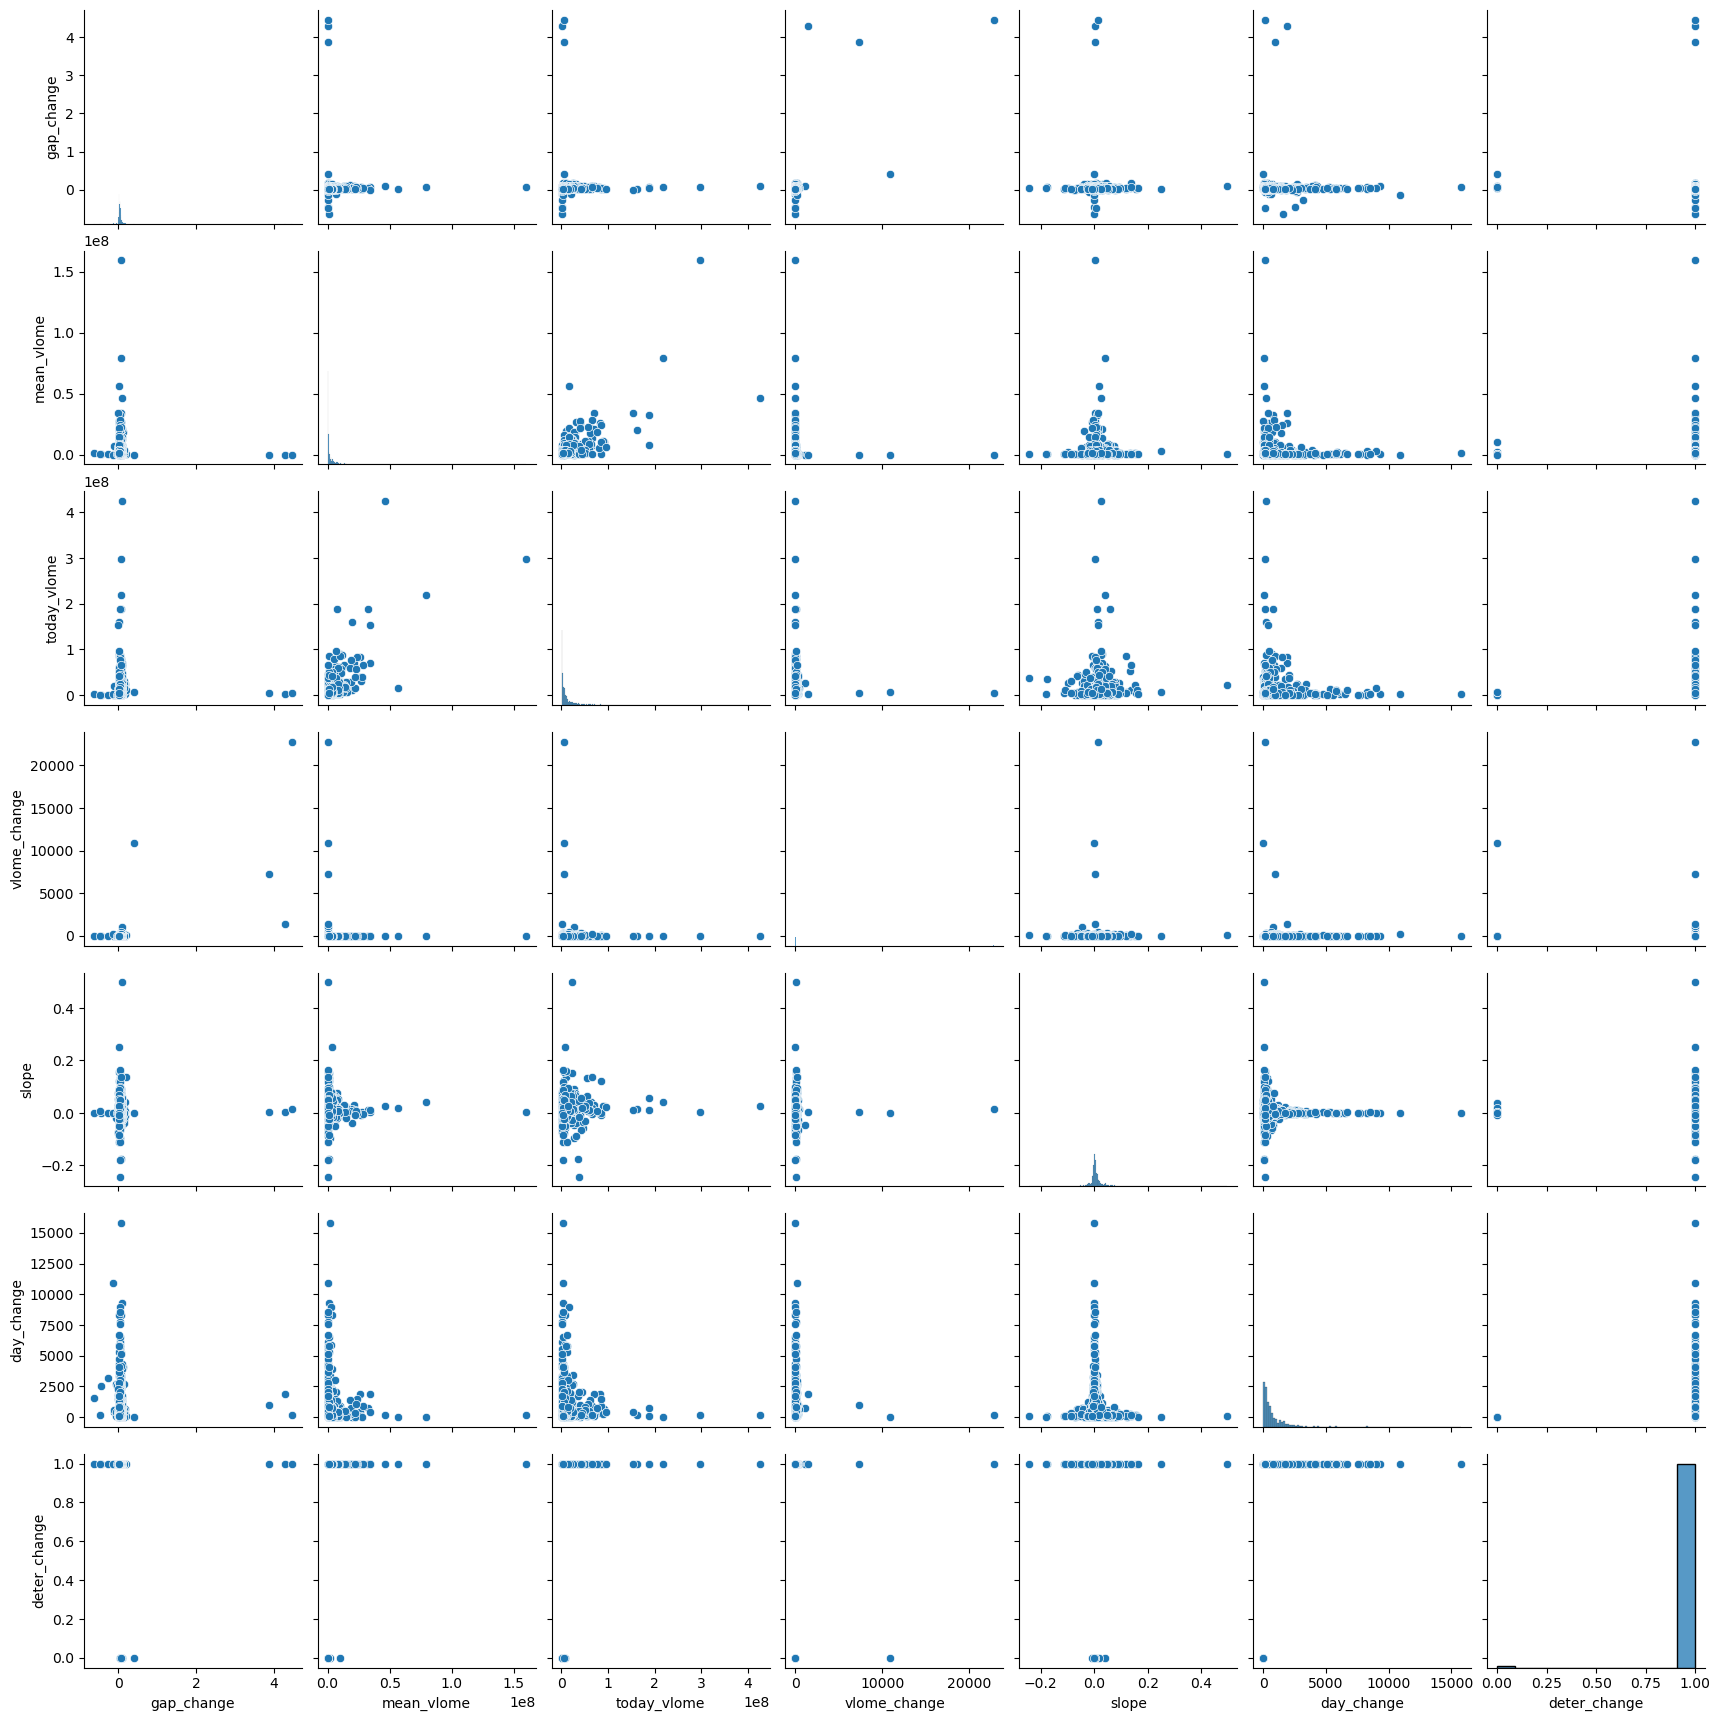

In [101]:
%matplotlib inline
sns.pairplot(stock_data)

In [106]:
Y = stock_data['deter_change']
X = stock_data[['today_vlome','slope','gap_change','vlome_change','mean_vlome']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print( results.summary())

Optimization terminated successfully.
         Current function value: 0.037229
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  902
Model:                          Logit   Df Residuals:                      896
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                  0.1806
Time:                        18:24:11   Log-Likelihood:                -33.581
converged:                       True   LL-Null:                       -40.984
Covariance Type:            nonrobust   LLR p-value:                   0.01122
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0121      0.547      7.338      0.000       2.940       5.084
today_vlome   4.008e-0